In [1]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.ops as ops
from cnn import CNN

In [2]:
torch.cuda.set_device(0)
device = torch.device('cuda')
loss_function = nn.CrossEntropyLoss()

In [3]:
masks = torch.tensor(np.load("masks.npy"))
images = torch.tensor(np.load("images.npy"))

cropped_images = []
for i in range(images.shape[0]):
    points = ops.masks_to_boxes(masks[i].unsqueeze(0)).int().tolist()[0]
    img = images[i][points[1]:points[3], points[0]:points[2]]
    img = cv.resize(img.numpy(), (64, 64))
    cropped_images.append(img)
images = np.stack(cropped_images)

In [4]:
labels = []
directory = "train\\"
for folder in os.listdir(directory):
    inner_directory = os.path.join(directory, folder)
    for file in os.listdir(inner_directory):
        labels.append(int(folder))
        labels.append(int(folder))
        labels.append(int(folder))
        labels.append(int(folder))
labels = np.stack(labels)

In [ ]:
images = torch.tensor(images, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long) - 1

# 80:20 split when validating
# split = int(images.shape[0]*0.8)

# 100:0 split when training model to submit
split = int(images.shape[0]*1)
train_images = images[:split]
train_labels = labels[:split]

val_images = images[split:]
val_labels = labels[split:]

print(train_labels.shape)
print(val_labels.shape)

torch.Size([1348])
torch.Size([0])


In [6]:
model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.to(device)

CNN(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(5, 5))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(3, 3))
    (3): ReLU()
    (4): Conv2d(64, 256, kernel_size=(3, 3), stride=(3, 3))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=4, bias=True)
  )
)

In [7]:
def val_loss():
	val_losses = []
	model.eval()
	for i in range(val_images.shape[0]):
		x = val_images[i:i+1]
		y = val_labels[i:i+1]
		
		x = x.to(device)
		y = y.to(device)

		logits = model(x.permute(0, 3, 1, 2))
		loss = loss_function(logits, y)
		val_losses.append(loss.item())
	model.train();
	return sum(val_losses)/len(val_losses)

In [8]:
losses = []

In [9]:
n_epochs = 50
batch_size = 16

for epoch in range(n_epochs):
	permutation = torch.randperm(train_images.shape[0])
	for i in range(0, permutation.shape[0], batch_size):
		optimizer.zero_grad()

		indices = permutation[i:i+batch_size]
		x, y = train_images[indices], train_labels[indices]

		x = x.to(device)
		y = y.to(device)

		logits = model(x.permute(0, 3, 1, 2))
		loss = loss_function(logits, y)
		losses.append(loss.item())
		
		loss.backward()
		optimizer.step()
	# print(val_loss())

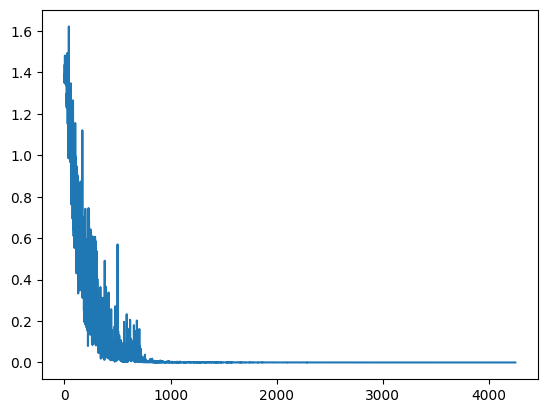

In [10]:
plt.plot(losses)

In [10]:
model.eval()
val_losses = []
for i in range(val_images.shape[0]):
	x = val_images[i:i+1]
	y = val_labels[i:i+1]
	
	x = x.to(device)
	y = y.to(device)

	logits = model(x.permute(0, 3, 1, 2))
	loss = loss_function(logits, y)
	val_losses.append(loss.item())
print(sum(val_losses)/len(val_losses))
model.train();

0.20035929015041953


In [11]:
torch.save(model.state_dict(), "models/cnn.pt")